# VendorClose AI - Smart End-of-Day Fruit Scanner
## Machine Learning Pipeline: Training, Evaluation, and Testing

This notebook demonstrates:
1. Data Acquisition and Preprocessing
2. Model Creation with Transfer Learning
3. Model Training with Optimization Techniques
4. Comprehensive Model Evaluation (4+ metrics)
5. Model Testing and Predictions


## 1. Setup and Imports


In [11]:
import sys
import os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd

# Import our custom modules
from src.preprocessing import ImagePreprocessor, create_medium_class_from_dataset
from src.model import FruitQualityClassifier
from src.prediction import FruitPredictor

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU Available: []


## 2. Data Acquisition


In [12]:
# Data directory structure
data_dir = Path('../data')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

print(" Data Acquisition")
print("=" * 50)
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

# Check if directories exist
if train_dir.exists():
    print("\n Training data directory found")
    # Count images in each class
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            img_count = len(list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png')))
            print(f"  - {class_dir.name}: {img_count} images")
else:
    print("\n  Training data directory not found")
    print("Please download the dataset from:")
    print("https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification")


 Data Acquisition
Train directory: ..\data\train
Test directory: ..\data\test

 Training data directory found
  - freshapples: 2424 images
  - freshbanana: 2468 images
  - freshbittergroud: 327 images
  - freshcapsicum: 990 images
  - freshcucumber: 496 images
  - freshokra: 635 images
  - freshoranges: 1466 images
  - freshpotato: 536 images
  - freshtomato: 1858 images
  - medium: 0 images
  - rottenapples: 3248 images
  - rottenbanana: 2932 images
  - rottenbittergroud: 357 images
  - rottencapsicum: 901 images
  - rottencucumber: 421 images
  - rottenokra: 338 images
  - rottenoranges: 1595 images
  - rottenpotato: 802 images
  - rottentomato: 1825 images


## 3. Data Preprocessing


In [13]:
# Create medium class if needed
if train_dir.exists():
    create_medium_class_from_dataset('../data')

# Initialize preprocessor
preprocessor = ImagePreprocessor(img_size=(160, 160), batch_size=128)

# Create data generators with augmentation
print("\n Data Preprocessing")
print("=" * 50)

if train_dir.exists():
    train_gen, val_gen, test_gen = preprocessor.create_data_generators(
        train_dir=str(train_dir),
        val_dir=str(train_dir),  # Validation split from training
        test_dir=str(test_dir) if test_dir.exists() else None
    )
    
    print(f"\n Data generators created")
    print(f"Classes: {train_gen.class_indices}")
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    if test_gen:
        print(f"Test samples: {test_gen.samples}")
else:
    print("  Cannot create data generators - data directory not found")


No medium class images created - ensure fresh/rotten classes exist

 Data Preprocessing
Found 18901 images belonging to 19 classes.
Found 4718 images belonging to 19 classes.
Found 6738 images belonging to 14 classes.

 Data generators created
Classes: {'freshapples': 0, 'freshbanana': 1, 'freshbittergroud': 2, 'freshcapsicum': 3, 'freshcucumber': 4, 'freshokra': 5, 'freshoranges': 6, 'freshpotato': 7, 'freshtomato': 8, 'medium': 9, 'rottenapples': 10, 'rottenbanana': 11, 'rottenbittergroud': 12, 'rottencapsicum': 13, 'rottencucumber': 14, 'rottenokra': 15, 'rottenoranges': 16, 'rottenpotato': 17, 'rottentomato': 18}
Training samples: 18901
Validation samples: 4718
Test samples: 6738


## 4. Model Creation


In [14]:
print("\n  Model Creation")
print("=" * 50)

# Get number of classes from data generator
if 'train_gen' in locals():
    num_classes = len(train_gen.class_indices)
    print(f"Detected {num_classes} classes from data")
    print(f"Classes: {list(train_gen.class_indices.keys())}")
else:
    num_classes = 3  # Default fallback
    print(f"Warning: Using default {num_classes} classes (data generator not found)")

# Initialize classifier with correct number of classes
classifier = FruitQualityClassifier(
    num_classes=num_classes,  # Use detected number of classes
    img_size=(160, 160),
    learning_rate=0.001
)

# Build model with transfer learning (MobileNetV2)
model = classifier.build_model(use_pretrained=True)

# Compile model with optimizer
classifier.compile_model(optimizer_name='adam')

# Display model summary
print("\n Model Architecture:")
model.summary()

print("\n Model created with:")
print("  - Transfer Learning: MobileNetV2 (pretrained on ImageNet)")
print("  - Regularization: Dropout, L2, Batch Normalization")
print("  - Data Augmentation: Rotation, Zoom, Shift, Flip")
print("  - Optimizer: Adam")
print("  - Metrics: Accuracy, Precision, Recall, AUC")



  Model Creation
Detected 19 classes from data
Classes: ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'medium', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']

 Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,035 (9.27 MB)

 Trainable params: 169,235 (661.07 KB)

 Non-trainable params: 2,260,800 (8.62 MB)


 Model created with:
  - Transfer Learning: MobileNetV2 (pretrained on ImageNet)
  - Regularization: Dropout, L2, Batch Normalization
  - Data Augmentation: Rotation, Zoom, Shift, Flip
  - Optimizer: Adam
  - Metrics: Accuracy, Precision, Recall, AUC


## 5. Model Training



 Model Training
Epoch 1/10
Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6387 - auc: 0.9281 - loss: 3.5218 - precision: 0.8284 - recall: 0.4831
Epoch 1: val_loss improved from None to 1.53609, saving model to ../models/best_model.h5

Epoch 1: val_loss improved from None to 1.53609, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 534s 4s/step - accuracy: 0.7876 - auc: 0.9822 - loss: 2.5329 - precision: 0.9060 - recall: 0.6730 - val_accuracy: 0.8160 - val_auc: 0.9939 - val_loss: 1.5361 - val_precision: 0.8733 - val_recall: 0.7185 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9025 - auc: 0.9972 - loss: 1.1220 - precision: 0.9401 - recall: 0.8490
Epoch 2: val_loss improved from 1.53609 to 0.95476, saving model to ../models/best_model.h5

Epoch 2: val_loss improved from 1.53609 to 0.95476, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.9060 - auc: 0.9974 - loss: 0.9670 - precision: 0.9411 - recall: 0.8583 - val_accuracy: 0.8338 - val_auc: 0.9944 - val_loss: 0.9548 - val_precision: 0.8831 - val_recall: 0.7541 - learning_rate: 0.0010
Epoch 3/10
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9144 - auc: 0.9977 - loss: 0.7111 - precision: 0.9471 - recall: 0.8714
Epoch 3: val_loss improved from 0.95476 to 0.83564, saving model to ../models/best_model.h5

Epoch 3: val_loss improved from 0.95476 to 0.83564, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.9157 - auc: 0.9978 - loss: 0.6771 - precision: 0.9469 - recall: 0.8767 - val_accuracy: 0.8145 - val_auc: 0.9943 - val_loss: 0.8356 - val_precision: 0.8489 - val_recall: 0.7622 - learning_rate: 0.0010
Epoch 4/10
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9239 - auc: 0.9982 - loss: 0.6071 - precision: 0.9506 - recall: 0.8824
Epoch 4: val_loss improved from 0.83564 to 0.75184, saving model to ../models/best_model.h5

Epoch 4: val_loss improved from 0.83564 to 0.75184, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9205 - auc: 0.9980 - loss: 0.6050 - precision: 0.9490 - recall: 0.8806 - val_accuracy: 0.8387 - val_auc: 0.9949 - val_loss: 0.7518 - val_precision: 0.8717 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 5/10
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9213 - auc: 0.9980 - loss: 0.5823 - precision: 0.9474 - recall: 0.8849
Epoch 5: val_loss improved from 0.75184 to 0.73093, saving model to ../models/best_model.h5

Epoch 5: val_loss improved from 0.75184 to 0.73093, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.9206 - auc: 0.9981 - loss: 0.5757 - precision: 0.9468 - recall: 0.8852 - val_accuracy: 0.8372 - val_auc: 0.9935 - val_loss: 0.7309 - val_precision: 0.8666 - val_recall: 0.7959 - learning_rate: 0.0010
Epoch 6/10
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9186 - auc: 0.9980 - loss: 0.5699 - precision: 0.9454 - recall: 0.8852
Epoch 6: val_loss did not improve from 0.73093
148/148 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.9171 - auc: 0.9980 - loss: 0.5708 - precision: 0.9440 - recall: 0.8815 - val_accuracy: 0.8277 - val_auc: 0.9932 - val_loss: 0.7669 - val_precision: 0.8508 - val_recall: 0.7919 - learning_rate: 0.0010
Epoch 7/10

Epoch 6: val_loss did not improve from 0.73093
148/148 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.9171 - auc: 0.9980 - loss: 0.5708 - precision: 0.9440 - recall: 0.8815 - val_accuracy: 0.8277 - val_auc: 0.9932 - val_loss: 0.7669 - val_precision: 0.8508 - val_recall: 0.7919 - l

148/148 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.9204 - auc: 0.9980 - loss: 0.5416 - precision: 0.9456 - recall: 0.8894 - val_accuracy: 0.8190 - val_auc: 0.9940 - val_loss: 0.7282 - val_precision: 0.8470 - val_recall: 0.7872 - learning_rate: 0.0010
Epoch 10/10
Epoch 10/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9200 - auc: 0.9982 - loss: 0.5327 - precision: 0.9438 - recall: 0.8889
Epoch 10: val_loss improved from 0.72819 to 0.71394, saving model to ../models/best_model.h5

Epoch 10: val_loss improved from 0.72819 to 0.71394, saving model to ../models/best_model.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9206 - auc: 0.9982 - loss: 0.5335 - precision: 0.9437 - recall: 0.8893 - val_accuracy: 0.8372 - val_auc: 0.9936 - val_loss: 0.7139 - val_precision: 0.8621 - val_recall: 0.8080 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.
Restoring model weights from the end of the best epoch: 10.


Model saved to ../models/fruit_classifier.h5


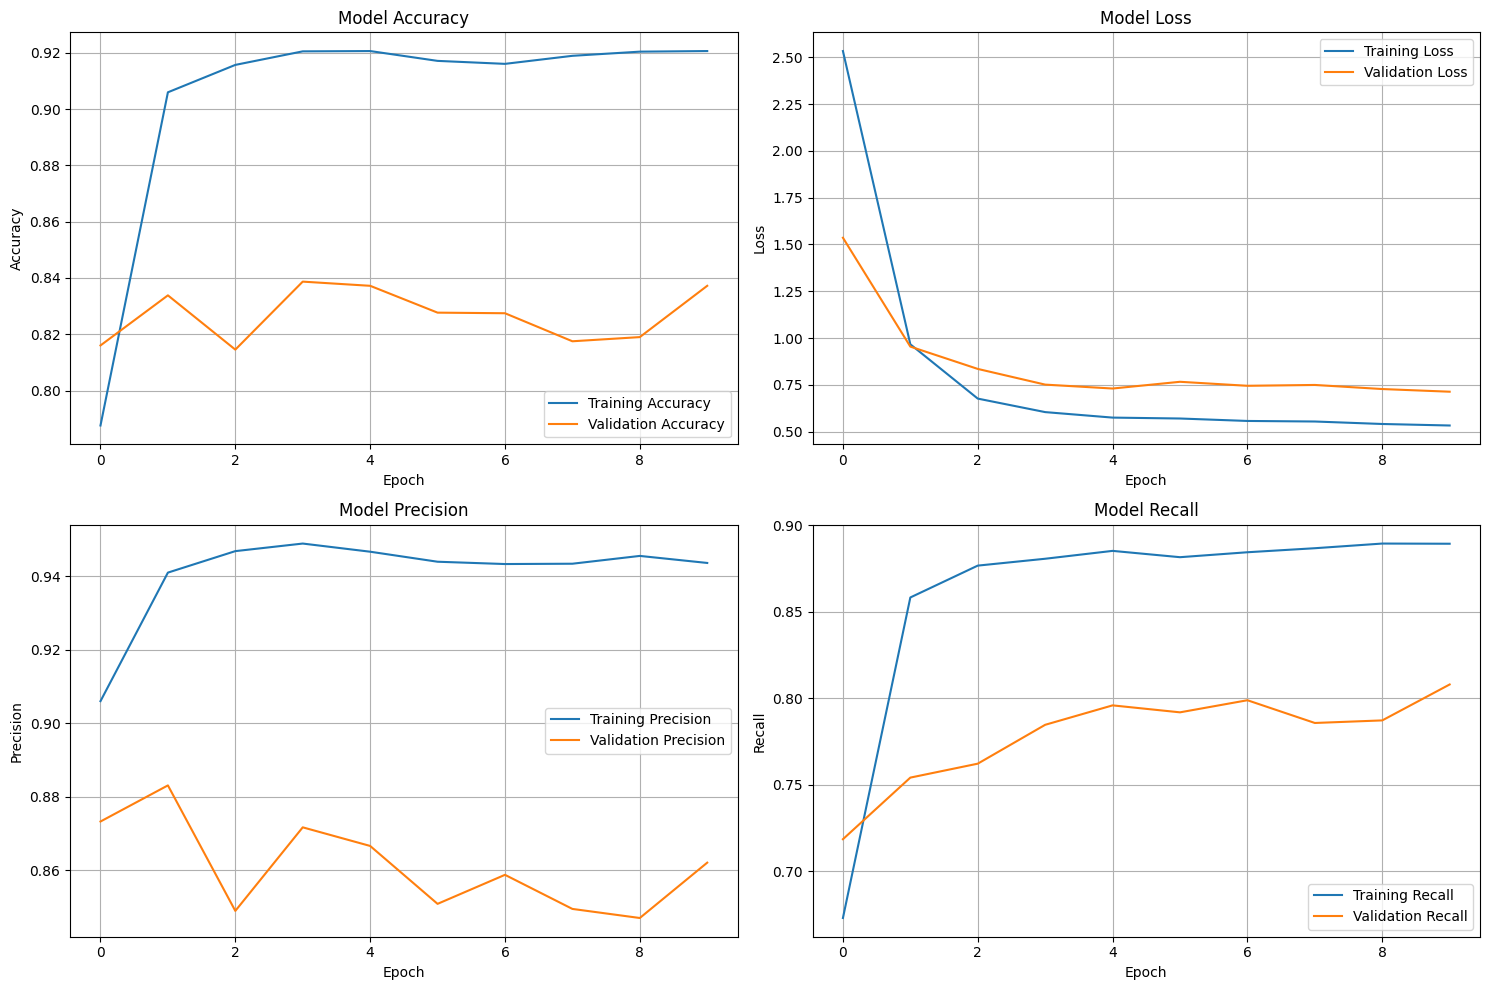


✅ Training completed!


In [23]:
print("\n Model Training")
print("=" * 50)

if train_dir.exists() and 'train_gen' in locals():
    # Ensure model output matches data generator classes to avoid shape mismatch
    num_classes = len(train_gen.class_indices)
    current_output = None
    if hasattr(classifier, 'model') and classifier.model is not None:
        try:
            current_output = classifier.model.output_shape[-1]
        except Exception:
            current_output = None

    if current_output != num_classes:
        print(f"  Mismatch detected: train generator has {num_classes} classes "
              f"but model outputs {current_output}. Rebuilding model to match classes...")
        # Rebuild classifier with correct number of classes
        # Preserve learning rate if available, otherwise default to 0.001
        lr = getattr(classifier, 'learning_rate', 0.001)
        classifier = FruitQualityClassifier(
            num_classes=num_classes,
            img_size=(160, 160),
            learning_rate=lr
        )
        # Build and compile new model
        model = classifier.build_model(use_pretrained=True)
        classifier.compile_model(optimizer_name='adam')
    else:
        # Make sure `model` variable references the classifier's model
        model = getattr(classifier, 'model', None)

    # Train the model
    # Limit the maximum epochs to 10 so training doesn't run unnecessarily long.
    # EarlyStopping (in `src/model.py`) will restore the best weights and stop earlier if no improvement.
    train_epochs = 10  # set a conservative max; adjust if you want longer training
    history = classifier.train(
        train_generator=train_gen,
        val_generator=val_gen,
        epochs=train_epochs,  # EarlyStopping may stop earlier
        batch_size=128
    )
    
    # Save the trained model
    classifier.save_model('../models/fruit_classifier.h5')
    
    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history.get('accuracy', []), label='Training Accuracy')
    axes[0, 0].plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history.get('loss', []), label='Training Loss')
    axes[0, 1].plot(history.history.get('val_loss', []), label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history.get('precision', []), label='Training Precision')
    axes[1, 0].plot(history.history.get('val_precision', []), label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history.get('recall', []), label='Training Recall')
    axes[1, 1].plot(history.history.get('val_recall', []), label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('../logs/training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nTraining completed!")
else:
    print("  Cannot train - data generators not available")



 Model Evaluation


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.0240 - auc: 0.5036 - loss: 5.8785 - precision: 0.0000e+00 - recall: 0.0000e+00

 Evaluation Metrics:
  Loss: 5.8785
  Accuracy: 0.0240 (2.40%)
  Precision: 0.0000 (0.00%)
  Recall: 0.0000 (0.00%)
  AUC: 0.5036
37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step

 Detailed Metrics:
  Weighted F1 Score: 0.0233 (2.33%)
  Weighted Precision: 0.0444 (4.44%)
  Weighted Recall: 0.0240 (2.40%)

 Classification Report:
                   precision    recall  f1-score   support

      freshapples       0.12      0.01      0.01       484
      freshbanana       0.01      0.01      0.01       493
 freshbittergroud       0.00      0.02      0.00        65
    freshcapsicum       0.03      0.01      0.01       198
    freshcucumber       0.03      0.13      0.05        99
        freshokra       0.00      0.00      0.00       127
     freshoranges       0.03      0.00      0.01       293
      freshpotato       0.05      0.03      0.03       107
      fresht

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

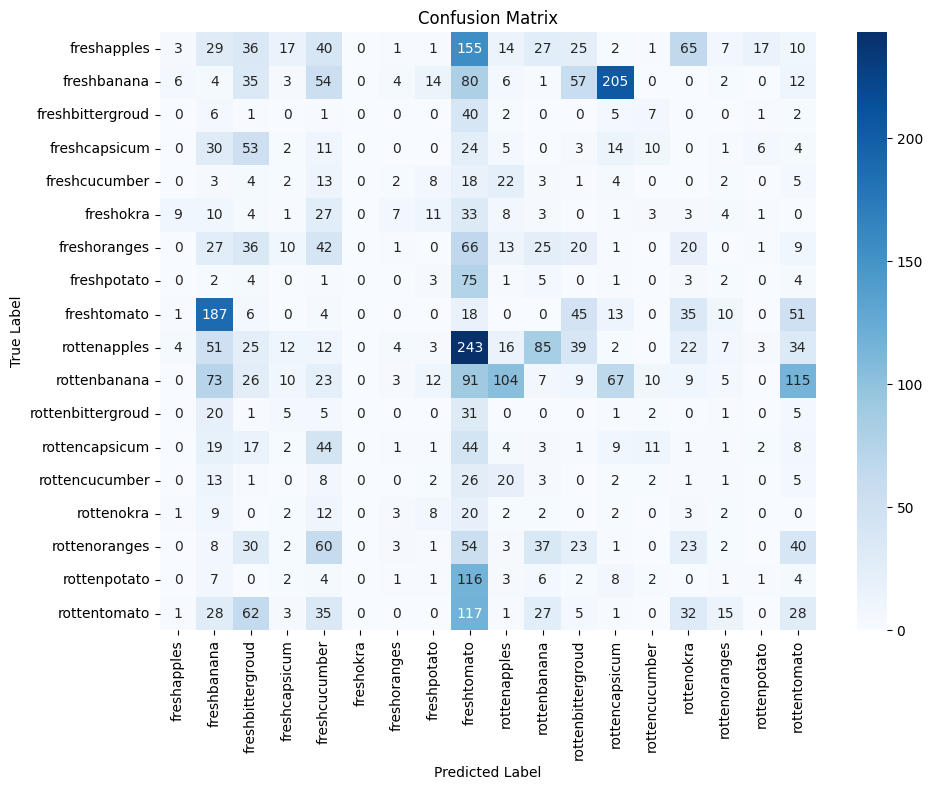


 Metrics Summary:
   Metric    Value
     Loss 5.878515
 Accuracy 0.023951
Precision 0.044378
   Recall 0.023951
 F1 Score 0.023307
      AUC 0.503572

 Evaluation completed with 6 metrics:
  1. Loss (Categorical Crossentropy)
  2. Accuracy
  3. Precision (Weighted)
  4. Recall (Weighted)
  5. F1 Score (Weighted)
  6. AUC (Area Under Curve)


In [15]:
print("\n Model Evaluation")
print("=" * 50)

if 'val_gen' in locals() and classifier.model is not None:
    # Evaluate on validation set
    eval_results = classifier.model.evaluate(val_gen, verbose=1)
    
    print("\n Evaluation Metrics:")
    print(f"  Loss: {eval_results[0]:.4f}")
    print(f"  Accuracy: {eval_results[1]:.4f} ({eval_results[1]*100:.2f}%)")
    print(f"  Precision: {eval_results[2]:.4f} ({eval_results[2]*100:.2f}%)")
    print(f"  Recall: {eval_results[3]:.4f} ({eval_results[3]*100:.2f}%)")
    print(f"  AUC: {eval_results[4]:.4f}")
    
    # Get predictions for detailed metrics
    val_gen.reset()
    y_pred = classifier.model.predict(val_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_gen.classes
    
    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    
    print("\n Detailed Metrics:")
    print(f"  Weighted F1 Score: {f1:.4f} ({f1*100:.2f}%)")
    print(f"  Weighted Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Weighted Recall: {recall:.4f} ({recall*100:.2f}%)")
    
    # Classification Report
    # Ensure target_names match the labels actually present in y_true to avoid mismatches.
    all_class_names = list(val_gen.class_indices.keys())
    present_labels = np.unique(y_true)  # labels actually present in the validation set
    # Map present label indices to their names
    names_for_present = [all_class_names[int(i)] for i in present_labels]
    
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred_classes, labels=present_labels.tolist(), target_names=names_for_present))
    
    # Confusion Matrix (use present_labels to align rows/cols with target names)
    cm = confusion_matrix(y_true, y_pred_classes, labels=present_labels.tolist())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=names_for_present, yticklabels=names_for_present)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('../logs/confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Metrics Summary DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
        'Value': [eval_results[0], eval_results[1], precision, recall, f1, eval_results[4]]
    })
    print("\n Metrics Summary:")
    print(metrics_df.to_string(index=False))
    
    print("\n Evaluation completed with 6 metrics:")
    print("  1. Loss (Categorical Crossentropy)")
    print("  2. Accuracy")
    print("  3. Precision (Weighted)")
    print("  4. Recall (Weighted)")
    print("  5. F1 Score (Weighted)")
    print("  6. AUC (Area Under Curve)")
else:
    print("  Cannot evaluate - model or validation generator not available")



 Model Testing

📦 Loading model...
🖼️  Using image size: 160x160 (matching trained model)


Model loaded from ../models/fruit_classifier.h5
Detected 19 classes from data directory: ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber']...
✅ Model loaded successfully with 19 classes

 Testing on 14 sample images:

  ✅ a_f001.png
     Class: freshapples
     Confidence: 98.40%
     Action: ✅ Keep overnight (Fresh - still good tomorrow)

  ✅ b_f001.png
     Class: freshbanana
     Confidence: 99.51%
     Action: ✅ Keep overnight (Fresh - still good tomorrow)

  ✅ c_f001.png
     Class: freshcucumber
     Confidence: 81.82%
     Action: ✅ Keep overnight (Fresh - still good tomorrow)

  ✅ o_f001.png
     Class: freshokra
     Confidence: 98.02%
     Action: ✅ Keep overnight (Fresh - still good tomorrow)

  ✅ rotated_by_15_Screen Shot 2018-06-12 at 11.50.41 PM.png
     Class: freshoranges
     Confidence: 99.42%
     Action: ✅ Keep overnight (Fresh - still good tomorrow)

  ✅ p_f001.png
     Class: freshpotato
     Confidence: 51.15%
     Action: ✅ Kee

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27240\1729565488.py:111: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27240\1729565488.py:111: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27240\1729565488.py:115: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../logs/test_predictions.png', dpi=150, bbox_inches='tight')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27240\1729565488.py:115: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../logs/test_predictions.png', dpi=150, bbox_inches='tight')



💾 Visualization saved to: ../logs/test_predictions.png


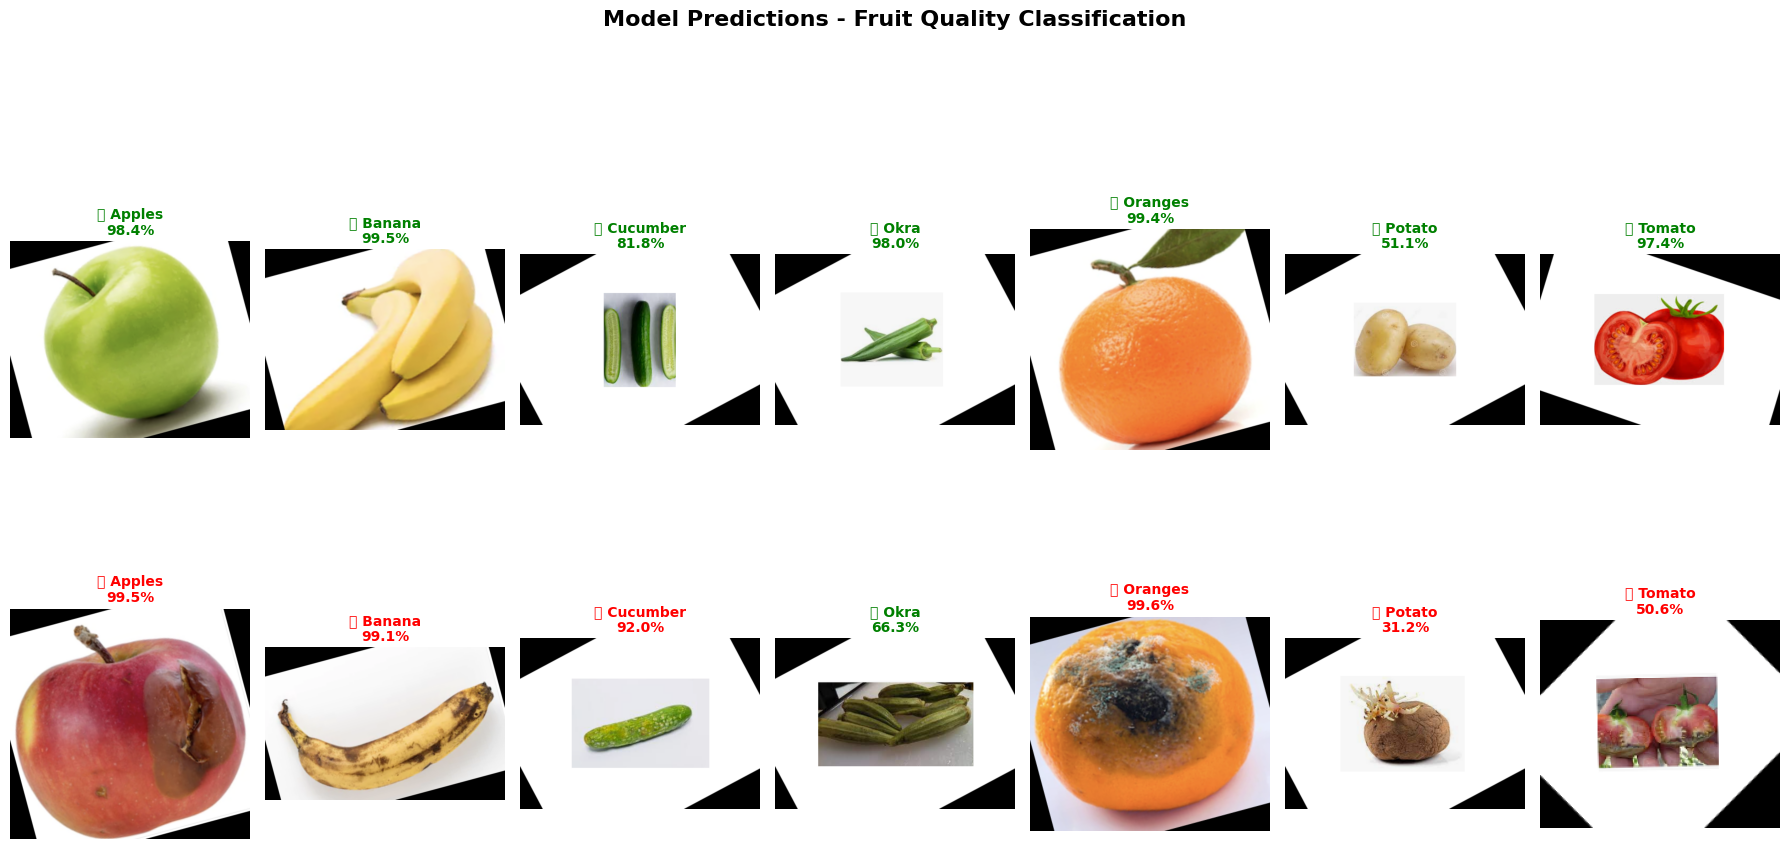

<Figure size 640x480 with 0 Axes>


 Testing completed!


In [7]:
print("\n Model Testing")

# Load predictor
# CRITICAL: Model was trained with 160x160 images - MUST use that size!
print("\n📦 Loading model...")
print("🖼️  Using image size: 160x160 (matching trained model)")

# Load predictor with CORRECT image size - THIS IS CRITICAL!
predictor = FruitPredictor(
    model_path='../models/fruit_classifier.h5',
    data_dir='../data',
    img_size=(160, 160)  # MUST be 160x160, NOT 224x224!
)

try:
    predictor.load_model(data_dir='../data')
    print(f"✅ Model loaded successfully with {len(predictor.class_names)} classes")
    
    # Test on a few sample images
    if test_dir.exists():
        # Get sample images from each class
        test_images = []
        for class_dir in test_dir.iterdir():
            if class_dir.is_dir():
                images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
                if images:
                    test_images.append(images[0])
        
        if test_images:
            print(f"\n Testing on {len(test_images)} sample images:")
            
            # Limit to 14 images for better display
            display_images = test_images[:14]
            num_images = len(display_images)
            
            # Better grid layout - 2 rows, 7 columns max
            cols = min(7, num_images)
            rows = (num_images + cols - 1) // cols
            
            # Larger figure size for better visibility
            fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
            fig.suptitle('Model Predictions - Fruit Quality Classification', fontsize=16, fontweight='bold', y=0.995)
            
            # Handle different axis configurations
            if num_images == 1:
                axes = [axes]
            elif rows == 1:
                axes = axes if isinstance(axes, np.ndarray) else [axes]
            else:
                axes = axes.flatten()
            
            for i, img_path in enumerate(display_images):
                try:
                    # Make prediction
                    result = predictor.predict_single(img_path)
                    
                    # Display image
                    img = plt.imread(img_path)
                    ax = axes[i] if num_images > 1 else axes[0]
                    ax.imshow(img)
                    ax.axis('off')
                    
                    # Format class name (cleaner display)
                    class_name = result['class']
                    if class_name.startswith('fresh'):
                        display_class = class_name.replace('fresh', '').title()
                        title_color = 'green'
                        emoji = '✅'
                    elif class_name.startswith('rotten'):
                        display_class = class_name.replace('rotten', '').title()
                        title_color = 'red'
                        emoji = '❌'
                    else:
                        display_class = class_name.title()
                        title_color = 'orange'
                        emoji = '⚠️'
                    
                    # Create clean, readable title
                    confidence_pct = result['confidence'] * 100
                    title = f"{emoji} {display_class}\n{confidence_pct:.1f}%"
                    
                    # Set title with better formatting
                    ax.set_title(title, fontsize=10, fontweight='bold', color=title_color, pad=5)
                    
                    # Add border color based on prediction
                    for spine in ax.spines.values():
                        spine.set_edgecolor(title_color)
                        spine.set_linewidth(2)
                    
                    print(f"\n  {emoji} {img_path.name}")
                    print(f"     Class: {result['class']}")
                    print(f"     Confidence: {result['confidence']:.2%}")
                    print(f"     Action: {result['action']}")
                    
                except Exception as e:
                    # Show error
                    try:
                        ax = axes[i] if num_images > 1 else axes[0]
                        ax.text(0.5, 0.5, f"Error:\n{str(e)[:30]}", 
                               ha='center', va='center', fontsize=8, color='red',
                               transform=ax.transAxes)
                        ax.axis('off')
                    except:
                        pass
                    print(f"\n  ❌ Error: {img_path.name} - {e}")
            
            # Hide unused subplots
            for i in range(len(display_images), len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            
            # Ensure logs directory exists
            Path('../logs').mkdir(exist_ok=True)
            plt.savefig('../logs/test_predictions.png', dpi=150, bbox_inches='tight')
            print(f"\n💾 Visualization saved to: ../logs/test_predictions.png")
            plt.show()
            plt.savefig('../logs/test_predictions.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print("\n Testing completed!")
        else:
            print("  No test images found")
    else:
        print("  Test directory not found")
        
except Exception as e:
    print(f"  Error during testing: {e}")
    print("Make sure the model has been trained first!")


## 8. Feature Visualization and Interpretation



📊 Feature Visualization
✅ Using model from classifier


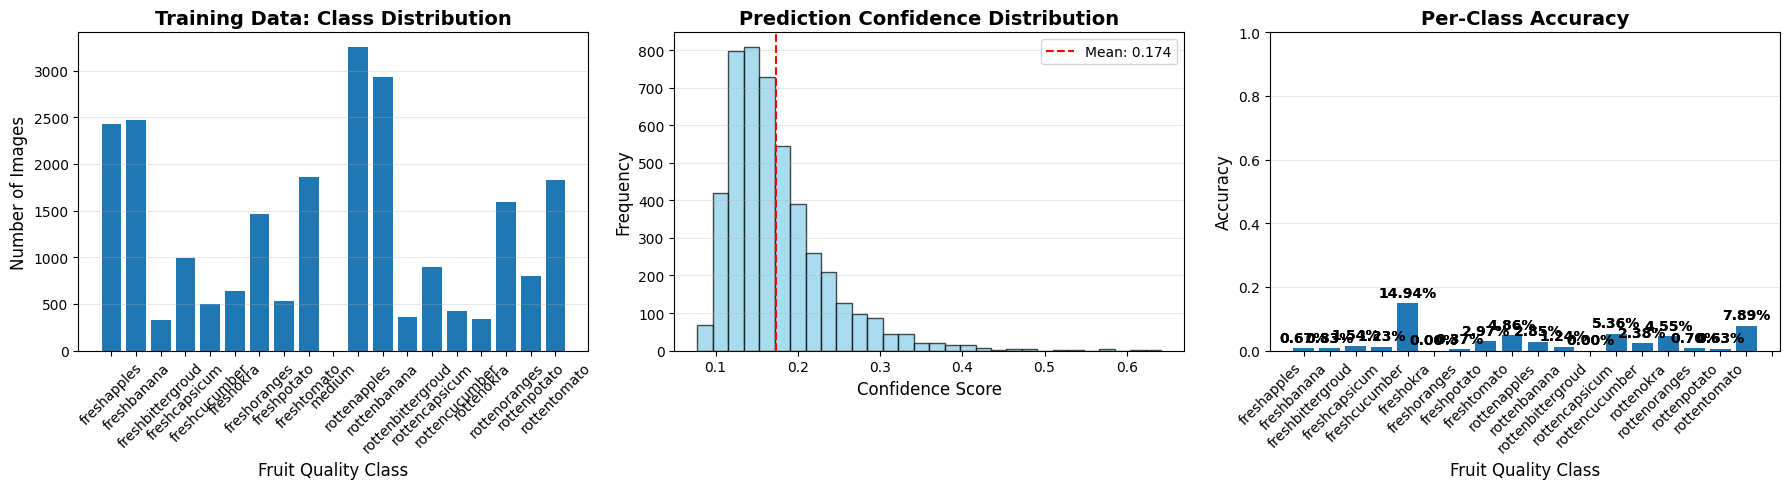


📖 Feature Interpretations:

1. Class Distribution:
   - Shows the balance of training data across quality classes
   - Balanced datasets lead to better model performance

2. Prediction Confidence:
   - Higher confidence scores indicate model certainty
   - Distribution helps identify ambiguous cases

3. Per-Class Accuracy:
   - Reveals which quality classes are easier/harder to predict
   - Helps identify areas for model improvement

✅ Feature visualization completed!


In [17]:
print("\n📊 Feature Visualization")
print("=" * 50)

# Ensure directories are defined
if 'train_dir' not in locals():
    data_dir = Path('../data')
    train_dir = data_dir / 'train'
    test_dir = data_dir / 'test'

if 'val_gen' in locals():
    # Get class names from validation generator
    class_names = list(val_gen.class_indices.keys())
    
    # Try to get model - either from classifier or load from file
    model = None
    if 'classifier' in locals() and hasattr(classifier, 'model') and classifier.model is not None:
        model = classifier.model
        print('✅ Using model from classifier')
    elif Path('../models/fruit_classifier.h5').exists():
        # Load model from file if classifier not available
        try:
            from tensorflow import keras
            model = keras.models.load_model('../models/fruit_classifier.h5')
            print('✅ Loaded model from file for visualization')
        except Exception as e:
            print(f'⚠️  Could not load model: {e}')
    
    if model is not None:
        # Get class distribution
        class_counts = {}
        for class_name in class_names:
            class_dir = train_dir / class_name
            if class_dir.exists():
                count = len(list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png')))
                class_counts[class_name] = count
        
        # Create visualizations
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Class Distribution
        axes[0].bar(class_counts.keys(), class_counts.values())
        axes[0].set_title('Training Data: Class Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Fruit Quality Class', fontsize=12)
        axes[0].set_ylabel('Number of Images', fontsize=12)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)
        
        # 2. Prediction Confidence Distribution
        if 'y_pred' in locals():
            max_probs = np.max(y_pred, axis=1)
            axes[1].hist(max_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            axes[1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Confidence Score', fontsize=12)
            axes[1].set_ylabel('Frequency', fontsize=12)
            axes[1].axvline(np.mean(max_probs), color='red', linestyle='--', 
                           label=f'Mean: {np.mean(max_probs):.3f}')
            axes[1].legend()
            axes[1].grid(axis='y', alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'Run evaluation cell first\nto see confidence distribution', 
                       ha='center', va='center', fontsize=12, 
                       transform=axes[1].transAxes)
            axes[1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        
        # 3. Per-Class Accuracy
        if 'cm' in locals() and 'y_true' in locals():
            # Get the labels actually used in confusion matrix
            present_labels = np.unique(y_true)
            
            # Calculate accuracies only for present classes
            class_accuracies = cm.diagonal() / cm.sum(axis=1)
            
            # Get class names for present labels only
            if 'val_gen' in locals():
                all_class_names = list(val_gen.class_indices.keys())
                present_class_names = [all_class_names[int(i)] for i in present_labels]
            else:
                present_class_names = [f'Class {i}' for i in present_labels]
            
            # Plot with matching dimensions
            axes[2].bar(range(len(present_class_names)), class_accuracies)
            axes[2].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
            axes[2].set_xlabel('Fruit Quality Class', fontsize=12)
            axes[2].set_ylabel('Accuracy', fontsize=12)
            axes[2].set_xticks(range(len(present_class_names)))
            axes[2].set_xticklabels(present_class_names, rotation=45, ha='right')
            axes[2].set_ylim([0, 1])
            axes[2].grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for j, acc in enumerate(class_accuracies):
                axes[2].text(j, acc + 0.02, f'{acc:.2%}', ha='center', fontweight='bold')
            axes[2].set_ylim([0, 1])
            axes[2].grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for j, acc in enumerate(class_accuracies):
                axes[2].text(j, acc + 0.02, f'{acc:.2%}', ha='center', fontweight='bold')
        else:
            axes[2].text(0.5, 0.5, 'Run evaluation cell first\nto see per-class accuracy', 
                       ha='center', va='center', fontsize=12, 
                       transform=axes[2].transAxes)
            axes[2].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        Path('../logs').mkdir(exist_ok=True)
        plt.savefig('../logs/feature_visualizations.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n📖 Feature Interpretations:")
        print("\n1. Class Distribution:")
        print("   - Shows the balance of training data across quality classes")
        print("   - Balanced datasets lead to better model performance")
        
        print("\n2. Prediction Confidence:")
        print("   - Higher confidence scores indicate model certainty")
        print("   - Distribution helps identify ambiguous cases")
        
        print("\n3. Per-Class Accuracy:")
        print("   - Reveals which quality classes are easier/harder to predict")
        print("   - Helps identify areas for model improvement")
        
        print("\n✅ Feature visualization completed!")
    else:
        print("⚠️  Model not available - cannot create visualizations")
        print("   Make sure to either:")
        print("   1. Run the training cell first, OR")
        print("   2. Have a trained model at ../models/fruit_classifier.h5")
else:
    print("⚠️  Cannot create visualizations - validation generator not available")
    print("   Run the data preprocessing cell first")
